# Projeto Final 

## Setup

In [1]:
from pyspark.sql import functions as sf
import pyspark.sql.functions as f

# Modeling
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
## Bibliotecas Gráficas
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Criar a sessao do Spark
from pyspark.sql import SparkSession
spark = SparkSession \
            .builder \
            .master("local[4]") \
            .appName("nyc_caio_garcia") \
            .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.4,com.microsoft.azure:azure-storage:8.6.6") \
            .getOrCreate()

In [4]:
# Acesso aos dados na nuvem
STORAGE_ACCOUNT = 'dlspadseastusprod'
CONTAINER = 'big-data-comp-nuvem'
FOLDER = 'airline-delay'
TOKEN = 'lSuH4ZI9BhOFEhCF/7ZQbrpPBIhgtLcPDfXjJ8lMxQZjaADW4p6tcmiZGDX9u05o7FqSE2t9d2RD+ASt0YFG8g=='

spark.conf.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)

### Schema
Schema definido de acordo com o dicionário de dados em `projeto_final_dicionário.xlsx`

In [5]:
from pyspark.sql.types import *

labels = (('FL_DATE', TimestampType()),
          ('OP_CARRIER', StringType()),
          ('OP_CARRIER_FL_NUM', IntegerType()),
          ('ORIGIN', StringType()),
          ('DEST', StringType()),
          ('CRS_DEP_TIME', IntegerType()),
          ('DEP_TIME', FloatType()),
          ('DEP_DELAY', FloatType()),
          ('TAXI_OUT', FloatType()),
          ('WHEELS_OFF', FloatType()),
          ('WHEELS_ON', FloatType()),
          ('TAXI_IN', FloatType()),
          ('CRS_ARR_TIME', IntegerType()),
          ('ARR_TIME', FloatType()),
          ('ARR_DELAY', FloatType()),
          ('CANCELLED', FloatType()),
          ('CANCELLATION_CODE', StringType()),
          ('DIVERTED', FloatType()),
          ('CRS_ELAPSED_TIME', FloatType()),
          ('ACTUAL_ELAPSED_TIME', FloatType()),
          ('AIR_TIME', FloatType()),
          ('DISTANCE', FloatType()),
          ('CARRIER_DELAY', FloatType()),
          ('WEATHER_DELAY', FloatType()),
          ('NAS_DELAY', FloatType()),
          ('SECURITY_DELAY', FloatType()),
          ('LATE_AIRCRAFT_DELAY', StringType()))

schema = StructType([StructField(x[0], x[1], True) for x in labels])

In [6]:
# Columns with values in minutes
minute_columns = ["TAXI_OUT","TAXI_IN","DEP_DELAY","ARR_DELAY","AIR_TIME","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME",
                  "CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]

# Subset from minute columns with no data leak from moment of take off
clean_min_columns = ["TAXI_OUT", "DEP_DELAY", "CRS_ELAPSED_TIME"]

# Columns with time information on format 'hhmm'
# Not proper for numerical manipulation
odd_format_columns = ["CRS_DEP_TIME","DEP_TIME","WHEELS_OFF","WHEELS_ON","ARR_TIME","CRS_ARR_TIME"]

### Carregamento de dados
Dados carregados da nuvem como spark data frame

Exemplo para o ano de 2009:

In [7]:
config = spark.sparkContext._jsc.hadoopConfiguration()
config.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)
sc = spark.sparkContext

df_exemple = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2009.csv"\
                    .format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, schema=schema)
df_exemple.take(2)

[Row(FL_DATE=datetime.datetime(2009, 1, 1, 0, 0), OP_CARRIER='XE', OP_CARRIER_FL_NUM=1204, ORIGIN='DCA', DEST='EWR', CRS_DEP_TIME=1100, DEP_TIME=1058.0, DEP_DELAY=-2.0, TAXI_OUT=18.0, WHEELS_OFF=1116.0, WHEELS_ON=1158.0, TAXI_IN=8.0, CRS_ARR_TIME=1202, ARR_TIME=1206.0, ARR_DELAY=4.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=62.0, ACTUAL_ELAPSED_TIME=68.0, AIR_TIME=42.0, DISTANCE=199.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELAY=None, SECURITY_DELAY=None, LATE_AIRCRAFT_DELAY=None),
 Row(FL_DATE=datetime.datetime(2009, 1, 1, 0, 0), OP_CARRIER='XE', OP_CARRIER_FL_NUM=1206, ORIGIN='EWR', DEST='IAD', CRS_DEP_TIME=1510, DEP_TIME=1509.0, DEP_DELAY=-1.0, TAXI_OUT=28.0, WHEELS_OFF=1537.0, WHEELS_ON=1620.0, TAXI_IN=4.0, CRS_ARR_TIME=1632, ARR_TIME=1624.0, ARR_DELAY=-8.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=82.0, ACTUAL_ELAPSED_TIME=75.0, AIR_TIME=43.0, DISTANCE=213.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELAY=None, SEC

Como temos dados para os anos de 2009 até o ano de 2018. Iremos criar um dicionario contendo os dataframes de cada ano separadamente. 

In [8]:
# Criando dicionario de dataframes
df_for_year = {}

# Loop lendo arquivo de cada ano e salvando no dicionario
for year in range(2009, 2019):
    # Ajustando o caminho
    file_path = "wasbs://{}@{}.blob.core.windows.net/{}/{}.csv"\
                    .format(CONTAINER, STORAGE_ACCOUNT, FOLDER, year)
    
    # lendo arquivo csv 
    df_name = "df_{}".format(year)
    df = spark.read.csv(file_path, header=True, schema=schema)
    
    # Adicionando df ao dicionario de dataframes 
    df_for_year[df_name] = df
    

# Visualizando as primeiras linhas de 2012
df_for_year["df_2012"].take(5)

[Row(FL_DATE=datetime.datetime(2012, 1, 1, 0, 0), OP_CARRIER='MQ', OP_CARRIER_FL_NUM=4041, ORIGIN='BMI', DEST='ORD', CRS_DEP_TIME=None, DEP_TIME=1702.0, DEP_DELAY=-13.0, TAXI_OUT=9.0, WHEELS_OFF=1711.0, WHEELS_ON=1748.0, TAXI_IN=9.0, CRS_ARR_TIME=None, ARR_TIME=1757.0, ARR_DELAY=-13.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=55.0, ACTUAL_ELAPSED_TIME=55.0, AIR_TIME=37.0, DISTANCE=116.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELAY=None, SECURITY_DELAY=None, LATE_AIRCRAFT_DELAY=None),
 Row(FL_DATE=datetime.datetime(2012, 1, 1, 0, 0), OP_CARRIER='MQ', OP_CARRIER_FL_NUM=4041, ORIGIN='ORD', DEST='BMI', CRS_DEP_TIME=None, DEP_TIME=1540.0, DEP_DELAY=-5.0, TAXI_OUT=11.0, WHEELS_OFF=1551.0, WHEELS_ON=1614.0, TAXI_IN=5.0, CRS_ARR_TIME=None, ARR_TIME=1619.0, ARR_DELAY=-16.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=50.0, ACTUAL_ELAPSED_TIME=39.0, AIR_TIME=23.0, DISTANCE=116.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELAY=None, 

Com todos os dataframes pré-importados(lazy) podemos realizar um merge unindo todos os anos.

In [9]:
# Importando função reduce para realizar o merge
from functools import reduce 

In [10]:
# União de todos os DataFrames em um único Data frame
df_final = reduce(sf.DataFrame.union, df_for_year.values())

# Criando a coluna "year" baseada na coluna "date"
df_final = df_final.withColumn("year", sf.year("FL_DATE"))

# Exibindo as primeiras linhas
df_final.take(10)

[Row(FL_DATE=datetime.datetime(2009, 1, 1, 0, 0), OP_CARRIER='XE', OP_CARRIER_FL_NUM=1204, ORIGIN='DCA', DEST='EWR', CRS_DEP_TIME=1100, DEP_TIME=1058.0, DEP_DELAY=-2.0, TAXI_OUT=18.0, WHEELS_OFF=1116.0, WHEELS_ON=1158.0, TAXI_IN=8.0, CRS_ARR_TIME=1202, ARR_TIME=1206.0, ARR_DELAY=4.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=62.0, ACTUAL_ELAPSED_TIME=68.0, AIR_TIME=42.0, DISTANCE=199.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELAY=None, SECURITY_DELAY=None, LATE_AIRCRAFT_DELAY=None, year=2009),
 Row(FL_DATE=datetime.datetime(2009, 1, 1, 0, 0), OP_CARRIER='XE', OP_CARRIER_FL_NUM=1206, ORIGIN='EWR', DEST='IAD', CRS_DEP_TIME=1510, DEP_TIME=1509.0, DEP_DELAY=-1.0, TAXI_OUT=28.0, WHEELS_OFF=1537.0, WHEELS_ON=1620.0, TAXI_IN=4.0, CRS_ARR_TIME=1632, ARR_TIME=1624.0, ARR_DELAY=-8.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=82.0, ACTUAL_ELAPSED_TIME=75.0, AIR_TIME=43.0, DISTANCE=213.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELA

Assim, temos o dataframe com todos os anos.

Criando um cahce do df_final para acelerar o processamento dos dados.

In [11]:
df_final.cache()

DataFrame[FL_DATE: timestamp, OP_CARRIER: string, OP_CARRIER_FL_NUM: int, ORIGIN: string, DEST: string, CRS_DEP_TIME: int, DEP_TIME: float, DEP_DELAY: float, TAXI_OUT: float, WHEELS_OFF: float, WHEELS_ON: float, TAXI_IN: float, CRS_ARR_TIME: int, ARR_TIME: float, ARR_DELAY: float, CANCELLED: float, CANCELLATION_CODE: string, DIVERTED: float, CRS_ELAPSED_TIME: float, ACTUAL_ELAPSED_TIME: float, AIR_TIME: float, DISTANCE: float, CARRIER_DELAY: float, WEATHER_DELAY: float, NAS_DELAY: float, SECURITY_DELAY: float, LATE_AIRCRAFT_DELAY: string, year: int]

In [12]:
OBSERVACOES = df_final.count()
assert (OBSERVACOES == 61556964)

In [13]:
OBSERVACOES

61556964

A base contem 61556964 observações.

In [13]:
CANCELAMENTOS = df_final.filter(df_final.CANCELLED == 1).count()
assert (CANCELAMENTOS == 973209)

In [14]:
CANCELAMENTOS

973209

Dos voos na base, 973209 foram cancelados.

## Tratamento de dados faltantes

Nesta etapa será realizada uma ánalise de valores nulos em cada variavel preditora.

### Resumo Geral

Primeiramente iremos ánalisar a quantidade de valores nulos por coluna.

In [17]:
# Agrupando e calculando o numero de valores nulos por coluna
missing_counts = df_final.select([sf.col(column).isNull().cast("int").alias(column) for column in df_final.columns]) \
                       .groupBy() \
                       .sum()

In [18]:
# Criando dataframe de colunas com valores zerados
missing_counts_df = missing_counts.toPandas().transpose()

# Filtrando apenas colunas com valores nulos
missing_counts_df = missing_counts_df[missing_counts_df[0]>0]

# Renomeando a coluna
missing_counts_df = missing_counts_df.rename(columns={0:"nulos"})

In [19]:
# Contando número de colunas com valores nulos
print("Número de colunas com valores faltantes:")
missing_counts_df.count()[0]

Número de colunas com valores faltantes:


19

In [20]:
# Cálculando porcentagem de valores faltantes
missing_counts_df["%nulos"] = (missing_counts_df["nulos"]/OBSERVACOES) * 100

# Ordenando por % de nulos
missing_counts_df = missing_counts_df.sort_values("%nulos", ascending=False)

# Visualizando resultados
missing_counts_df

,nulos,%nulos
sum(CANCELLATION_CODE),60583755,98.419011
sum(LATE_AIRCRAFT_DELAY),50166224,81.495611
sum(SECURITY_DELAY),50166224,81.495611
sum(NAS_DELAY),50166224,81.495611
sum(WEATHER_DELAY),50166224,81.495611
sum(CARRIER_DELAY),50166224,81.495611
sum(CRS_ARR_TIME),6096762,9.904260
sum(CRS_DEP_TIME),6096762,9.904260
sum(ARR_DELAY),1121351,1.821648
sum(ACTUAL_ELAPSED_TIME),1118754,1.817429


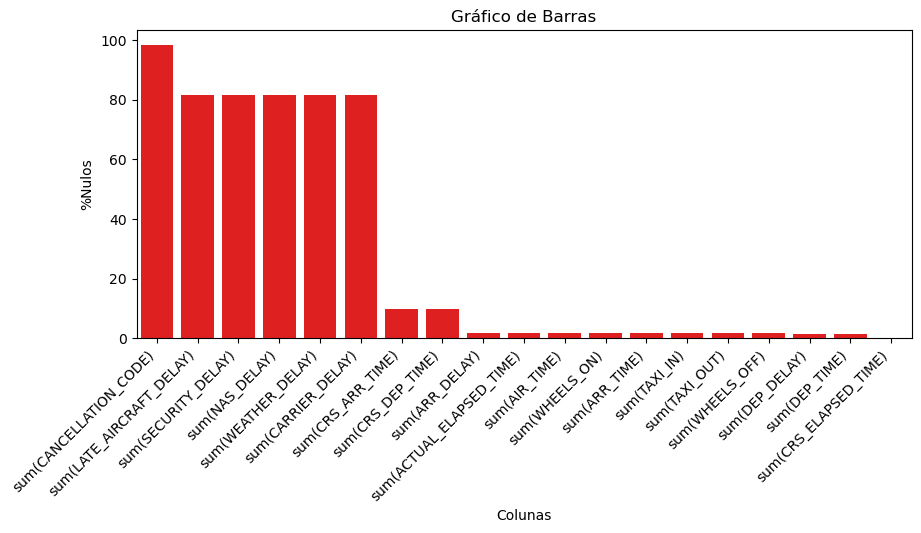

In [21]:
# Visualizando missing em gráfico de barras
# Ajustando o tamanho da figura
plt.figure(figsize=(10, 4))

# Plotando o gráfico de barras
sns.barplot(x=missing_counts_df.index, y=missing_counts_df["%nulos"], color="red")

# Adicionando inclinação aos valores do eixo x
plt.xticks(rotation=45, ha='right')

# Adicionando título e rótulos aos eixos
plt.title('Gráfico de Barras')
plt.xlabel("Colunas")
plt.ylabel("%Nulos")

# Exibindo o gráfico
plt.show()

Conforme evidenciado no gráfico apresentado, nota-se que a coluna "CANCELLATION_CODE" exibe uma lacuna em praticamente 100% dos dados, enquanto as colunas "LATE_AIRCRAFT_DELAY", "NAS_DELAY", "WEATHER_DELAY", "CARRIER_DELAY" e "SECURITY_DELAY" apresentam uma ausência de informações em torno de 80%.

Das 27 colunas na base de dados, 19 tem valores faltantes. Para compreender melhor o impacto desses valores nulos, iremos dividir esta ánalise em 4 grupos: _Cancelamentos_, _Voo_, _Chegada_ e _Atrasos_

### Cancelamentos

Dentre as colunas que indicam se o voo foi cancelado, temos a coluna CANCELLATION_CODE e CANCELLED. Nesta etapa iremos verificar se essas volunas possuem valores nulos iguais, em outras palavras, se o código descrito na coluna CANCELLATION_CODE corresponde aos voos demarcados como cancelados na coluna CANCELLED.

In [22]:
try:
    assert (df_final.filter((df_final.CANCELLATION_CODE.isNull()) &
                  (df_final.CANCELLED == 0)).count() ==
        df_final.filter(df_final.CANCELLED == 0).count())
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade atendida


Todos os valores faltantes de CANCELLATION_CODE são referentes a voos que não foram cancelados.

### Voo

O grupo _Voo_ apresenta uma relação entre voos cancelados e as 7 variáveis:
 - DEP_TIME
 - DEP_DELAY
 - TAXI_OUT
 - WHEELS_OFF
 - WHEELS_ON
 - TAXI_IN
 - ARR_TIME

#### Testes

`DEP_TIME` e `DEP_DELAY`: co-ausentes, em todos os voos cancelados

O primeiro teste realizado será conferindo se as colunas DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN e ARR_TIME estão contidas dentro da coluna DEP_TIME.

In [23]:
try:
    assert (
        df_final.filter(
            (df_final.DEP_TIME.isNull()) &
            (df_final.DEP_DELAY.isNull()) &
            (df_final.TAXI_OUT.isNull()) &
            (df_final.WHEELS_OFF.isNull()) &
            (df_final.WHEELS_ON.isNull()) &
            (df_final.TAXI_IN.isNull()) &
            (df_final.ARR_TIME.isNull())
        ).count() ==
        df_final.filter(df_final.DEP_TIME.isNull()).count()
    )
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade atendida


Ao rodar o código acima, concluimos que essas colunas estão contidas na coluna DEP_TIME.

O próximo teste será com relação a coluna DEP_TIME e DEP_DELAY correspondem com relação ao número de linhas nulas.

In [24]:
try:
    assert (df_final.filter((df_final.DEP_TIME.isNull())   &
                  (df_final.DEP_DELAY.isNull())).count() ==
        df_final.filter(df_final.DEP_TIME.isNull()).count())
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade atendida


In [25]:
try:
    assert (df_final.filter((df_final.DEP_TIME.isNull())   &
                  (df_final.CANCELLED == 1)).count() ==
        df_final.filter(df_final.DEP_TIME.isNull()).count())
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade atendida


`TAXI_OUT` e `WHEELS_OFF`: co-ausentes e cancelados

In [26]:
try:
    assert (df_final.filter((df_final.TAXI_OUT.isNull())   &
                  (df_final.WHEELS_OFF.isNull()) &
                  (df_final.WHEELS_ON.isNull())  &
                  (df_final.TAXI_IN.isNull())    &
                  (df_final.ARR_TIME.isNull())).count() ==
        df_final.filter(df_final.TAXI_OUT.isNull()).count())
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade não atendida


In [27]:
try:
    assert (df_final.filter((df_final.TAXI_OUT.isNull())   &
                  (df_final.WHEELS_OFF.isNull())).count() ==
        df_final.filter(df_final.TAXI_OUT.isNull()).count())
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")


Igualdade não atendida


In [30]:
try:
    assert (df_final.filter((df_final.TAXI_OUT.isNull())   &
                  (df_final.CANCELLED == 1)).count() ==
       df_final.filter(df_final.TAXI_OUT.isNull()).count())
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade atendida


`WHEELS_ON`, `TAXI_IN` e `ARR_TIME`: co-ausentes

In [31]:
try:
    assert (df_final.filter((df_final.WHEELS_ON.isNull())  &
                  (df_final.TAXI_IN.isNull())    &
                  (df_final.ARR_TIME.isNull())).count() ==
        df_final.filter(df_final.TAXI_IN.isNull()).count())
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade não atendida


In [32]:
try:
    assert (df_final.filter((df_final.TAXI_IN.isNull())   &
                  (df_final.CANCELLED == 1)).count() ==
        df_final.filter(df_final.CANCELLED == 1).count())
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade atendida


In [35]:
try:
    assert (df_final.filter((df_final.TAXI_IN.isNull()) &
                  (df_final.CANCELLED == 0)   &
                  (df_final.DIVERTED == 1)).count() ==
        df_final.filter((df_final.TAXI_IN.isNull()) &
                  (df_final.CANCELLED == 0)).count())
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade não atendida


#### Análise

O grupo _Voo_ apresenta uma relação entre voos cancelados e as 7 variáveis:
 - DEP_TIME
 - DEP_DELAY
 - TAXI_OUT
 - WHEELS_OFF
 - WHEELS_ON
 - TAXI_IN
 - ARR_TIME
 
Os valores faltantes para WHEELS_ON, TAXI_IN e ARR_TIME coincidem nas mesmas observações (com uma exceção descrita mais abaixo). Todos os voos cancelados se encontram dentre essas observações. Os valores faltantes para TAXI_OUT e WHEELS_OFF coincidem nas mesmas observações, todas referentes a voos cancelados. Finalmente, os valores faltantes de DEP_TIME e DEP_DELAY coincidem nas mesmas observações, todas com valores faltantes para TAXI_OUT.

Todos os voos que não foram cancelados mas não tem informação da hora de aterrisagem (`(df.WHEELS_ON.isNull()) & (df.CANCELLED == 0)`) foram redirecionados para um aeroporto diferente do aeroporto destino original (`df.DIVERTED == 1`)

Destas relações, supomos:
 - A diferença entre DEP_TIME e WHEELS_OFF pode ser devido a voos que chegam a sair do chão antes de serem cancelados, e voos que são cancelados após o embarque mas antes da decolagem.
 - Nenhum desses valores faltantes parece implausível o suficiente para assumirmos erro nos dados baseado apenas nessa análise. Alguns desses dados podem vir a ser retirados mesmo assim por questão de propriedades dos algorítmos utilizados mais a frente.

### Chegada

### Atrasos
TODO

#### Testes

In [38]:
try:
    assert (df_final.filter((df_final.CANCELLED == 0) &
                  (df_final.DEP_DELAY > 0)).count() == 
        22280599)
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade atendida


In [40]:
try:
    assert (df_final.filter((df_final.CANCELLED == 0) &
                  (df_final.ARR_DELAY > 0)).count() ==
        22563856)
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")


Igualdade atendida


In [43]:
try:
    assert (df_final.filter((df_final.CANCELLED == 0) &
                  ((df_final.DEP_DELAY > 0) |
                   (df_final.ARR_DELAY > 0))).count() ==
        28817028)
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")


Igualdade atendida


In [45]:
try:
    assert (OBSERVACOES - df_final.filter(df_final.CARRIER_DELAY.isNull()).count() ==
        11390740)
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade atendida


In [46]:
try:
    assert (df_final.filter((df_final.CARRIER_DELAY.isNull()) &
                  (df_final.WEATHER_DELAY.isNull()) &
                  (df_final.NAS_DELAY.isNull()) &
                  (df_final.SECURITY_DELAY.isNull()) &
                  (df_final.LATE_AIRCRAFT_DELAY.isNull())).count() ==
        df_final.filter(df_final.CARRIER_DELAY.isNull()).count())
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade atendida


In [47]:
df_final.filter(df_final.CARRIER_DELAY == 0).select(df_final.OP_CARRIER_FL_NUM, df_final.CARRIER_DELAY).take(10)

[Row(OP_CARRIER_FL_NUM=1233, CARRIER_DELAY=0.0),
 Row(OP_CARRIER_FL_NUM=2042, CARRIER_DELAY=0.0),
 Row(OP_CARRIER_FL_NUM=2060, CARRIER_DELAY=0.0),
 Row(OP_CARRIER_FL_NUM=2081, CARRIER_DELAY=0.0),
 Row(OP_CARRIER_FL_NUM=2126, CARRIER_DELAY=0.0),
 Row(OP_CARRIER_FL_NUM=2236, CARRIER_DELAY=0.0),
 Row(OP_CARRIER_FL_NUM=2249, CARRIER_DELAY=0.0),
 Row(OP_CARRIER_FL_NUM=2261, CARRIER_DELAY=0.0),
 Row(OP_CARRIER_FL_NUM=2279, CARRIER_DELAY=0.0),
 Row(OP_CARRIER_FL_NUM=2287, CARRIER_DELAY=0.0)]

#### Análise

Todos os dados faltantes referentes a categoria de atraso coincidem nas mesmas observações.

Há menos observações com informação sobre a causa do atraso do que voos atrasados, independente se medindo o atraso de saída ou de chegada.

### Anomalia

In [48]:
try:
    assert (df_final.filter((df_final.ACTUAL_ELAPSED_TIME.isNull()) &
                  (df_final.AIR_TIME == 0)                &
                  (df_final.WHEELS_ON.isNull())           &
                  (df_final.ARR_TIME.isNull())            &
                  (df_final.ARR_DELAY == 0)               &
                  (df_final.TAXI_IN == 0)                 &
                  (df_final.CANCELLED == 0)).count() == 1)
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade atendida


Uma mesma observação é responsavel pela discrepância na quantidade total de valores faltantes entre WHEELS_ON, TAXI_IN e ARR_TIME, e ARR_DELAY, ACTUAL_ELAPSED_TIME e AIR_TIME.
Um valor de `AIR_TIME == 0` nao faz sentido para um voo que não foi cancelado, e o mesmo se aplica a `TAXI_IN == 0`. Ao retirar essa observação da base, a análise de dados faltantes por grupo torna-se mais consistente.

## Consistencia

In [49]:
try:
    assert (df_final.filter(df_final.AIR_TIME + df_final.TAXI_IN + df_final.TAXI_OUT != df_final.ACTUAL_ELAPSED_TIME).count() == 0)
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade atendida


In [50]:
try:
    assert (df_final.filter((df_final.CANCELLED == 1) &
                  (df_final.DIVERTED == 1)).count() == 0)
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade não atendida


In [12]:
try:
    assert (df_final.filter((df_final.DEP_TIME % 1 != 0) | (df_final.DEP_DELAY % 1 != 0)).count() == 0)
    print("Igualdade atendida")
except AssertionError:
    print("Igualdade não atendida")

Igualdade atendida


# Análise Exploratória

Nesta etapa foi realizada uma análise exploratória dos dados que entraram na modelagem, dentre elas 4 categoricas e 4 númericas.

Preditoras Númericas
- TAXI_OUT
- DEP_DELAY
- CRS_ELAPSED_TIME
- DISTANCE

Preditoras Categóricas:
- OP_CARRIER
- OP_CARRIER_FL_NUM
- ORIGIN
- DEST

### Númericas

Nesta etapa iresmo analisar a influência e correlação entre as váriaveis númericas e a váriavel target. Como estamos trabalhando com um número elevado de linhas, não é possivel utilizar uma amostra muito significativa dos dados para plotar os gráficos de dispersão. Para contornar este problema estamos considerando 6 amostras com 5% da base e seeds distintos para plotar o gráfico de dispersão e entender a relação desta variavel 

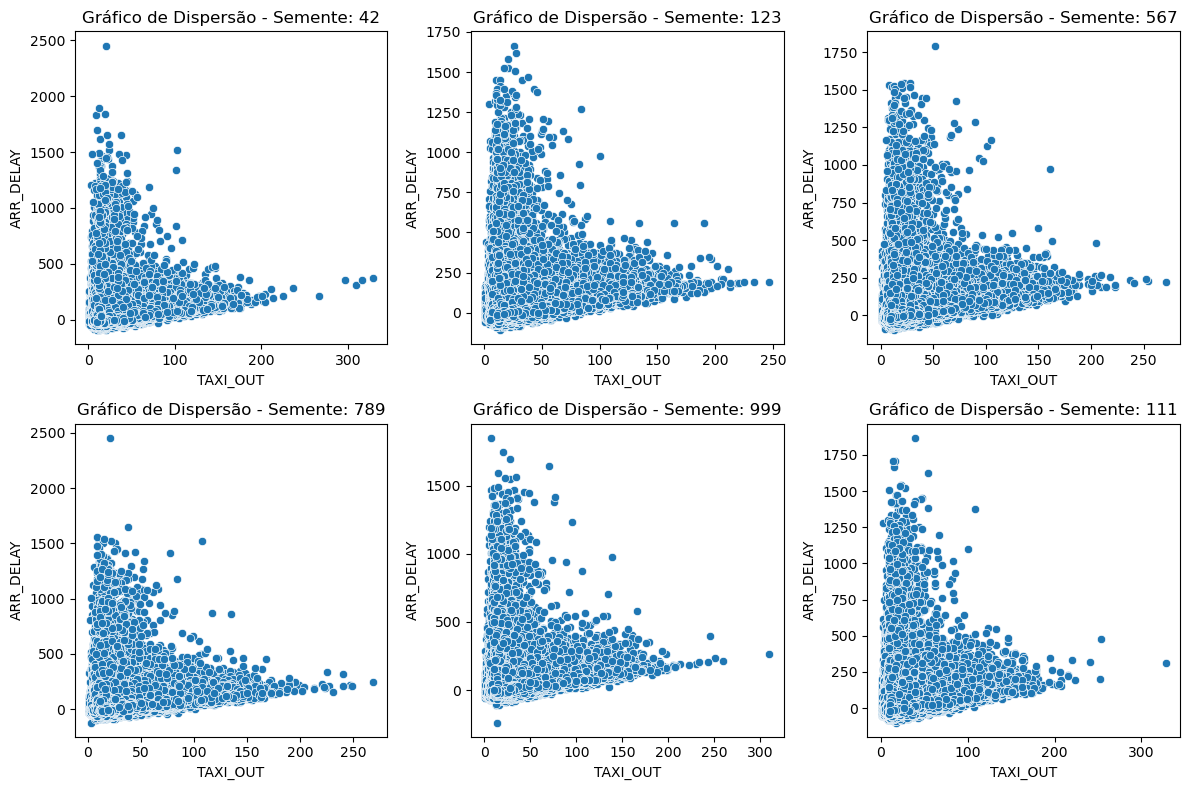

In [15]:
# Criando dataframe com as duas váriaveis
df_taxi_out_delay = df_final.select("TAXI_OUT", "ARR_DELAY")

# Lista de sementes aleatórias
sementes_aleatorias = [42, 123, 567, 789, 999, 111]

# Configurar subplots
num_linhas = int(len(sementes_aleatorias) / 3)
num_colunas = 3  # Você pode ajustar o número de colunas conforme necessário
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(12,8))

# Loop através das sementes
for i, semente in enumerate(sementes_aleatorias):
    # Criar uma amostra do DataFrame usando a semente
    df_amostra = df_taxi_out_delay.sample(withReplacement=False, fraction=0.05, seed=semente)

    # Coletar a amostra para o ambiente local (Pandas DataFrame)
    df_pandas = df_amostra.toPandas()

    # Realizar análise exploratória com Seaborn e Matplotlib
    # Converter axs[i] em um eixo individual usando [0]
    sns.scatterplot(x='TAXI_OUT', y='ARR_DELAY', data=df_pandas, ax=axs[i // num_colunas, i % num_colunas])
    axs[i // num_colunas, i % num_colunas].set_xlabel('TAXI_OUT')
    axs[i // num_colunas, i % num_colunas].set_ylabel('ARR_DELAY')
    axs[i // num_colunas, i % num_colunas].set_title(f'Gráfico de Dispersão - Semente: {semente}')

# Ajustar layout e exibir os subplots
plt.tight_layout()
plt.show()

Observando os resultados dos gráficos acima, fica evidente que não há um padrão linear entre o intervalo de tempo desde a saída do avião do portão até a decolagem e o atraso na aterrissagem. No entanto, é importante notar que não foram identificados atrasos significativos mesmo quando esse período de tempo até a decolagem é ampliado.

Realizando a ánalise com a segunda variável.

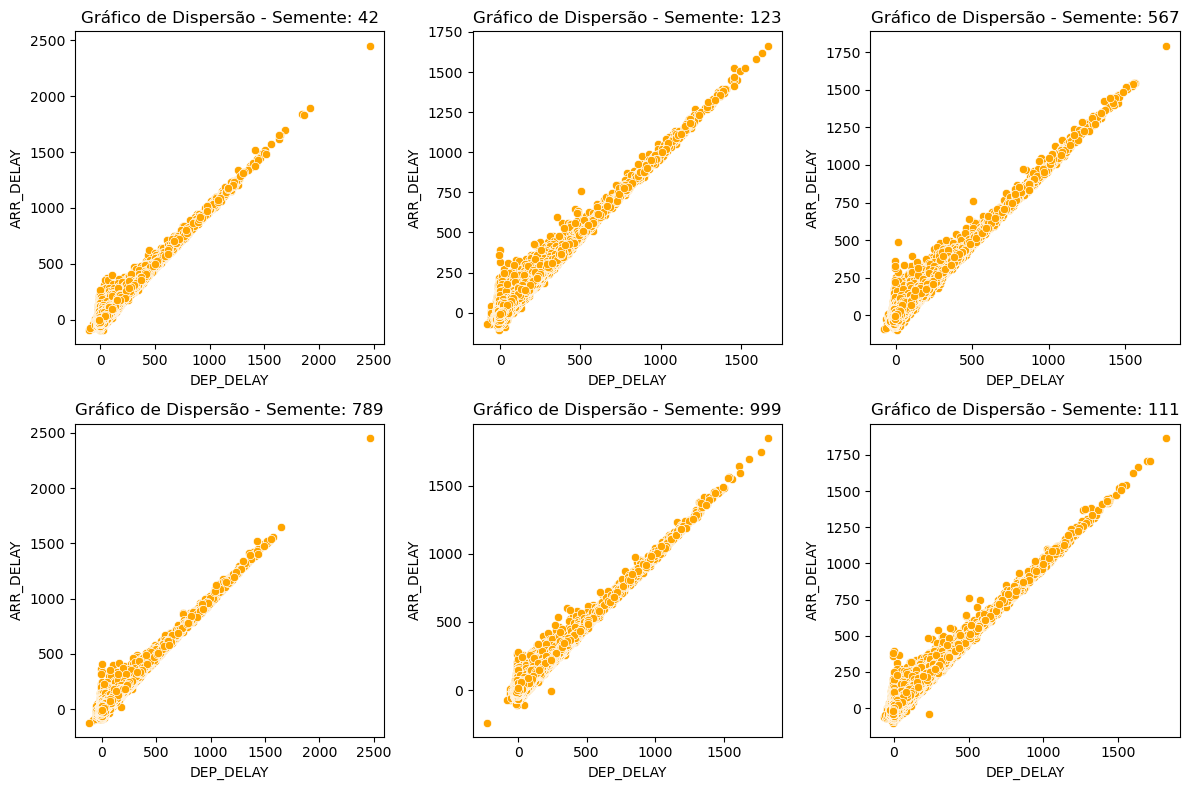

In [19]:
# Criando dataframe com as duas váriaveis
df_dep_delay_delay = df_final.select("DEP_DELAY", "ARR_DELAY")

# Lista de sementes aleatórias
sementes_aleatorias = [42, 123, 567, 789, 999, 111]

# Configurar subplots
num_linhas = int(len(sementes_aleatorias) / 3)
num_colunas = 3  # Você pode ajustar o número de colunas conforme necessário
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(12,8))

# Loop através das sementes
for i, semente in enumerate(sementes_aleatorias):
    # Criar uma amostra do DataFrame usando a semente
    df_amostra = df_dep_delay_delay.sample(withReplacement=False, fraction=0.05, seed=semente)

    # Coletar a amostra para o ambiente local (Pandas DataFrame)
    df_pandas = df_amostra.toPandas()

    # Realizar análise exploratória com Seaborn e Matplotlib
    # Converter axs[i] em um eixo individual usando [0]
    sns.scatterplot(x='DEP_DELAY', y='ARR_DELAY', data=df_pandas, ax=axs[i // num_colunas, i % num_colunas], color="orange")
    axs[i // num_colunas, i % num_colunas].set_xlabel('DEP_DELAY')
    axs[i // num_colunas, i % num_colunas].set_ylabel('ARR_DELAY')
    axs[i // num_colunas, i % num_colunas].set_title(f'Gráfico de Dispersão - Semente: {semente}')

# Ajustar layout e exibir os subplots
plt.tight_layout()
plt.show()

Como pode ser observado, existe uma relação linear quase perfeita entre o atraso na decolagem e o atraso na aterrissagem dos voos analisados. Em outras palavras, quanto maior for o atraso na decolagem, maior será o atraso na chegada do avião ao seu destino. Isso era esperado, no entanto, vale a pena notar que, em algumas subdivisões de seeds, voos sem atraso na decolagem também apresentaram atrasos na aterrissagem. Isso sugere que outros fatores também podem influenciar a variável alvo.

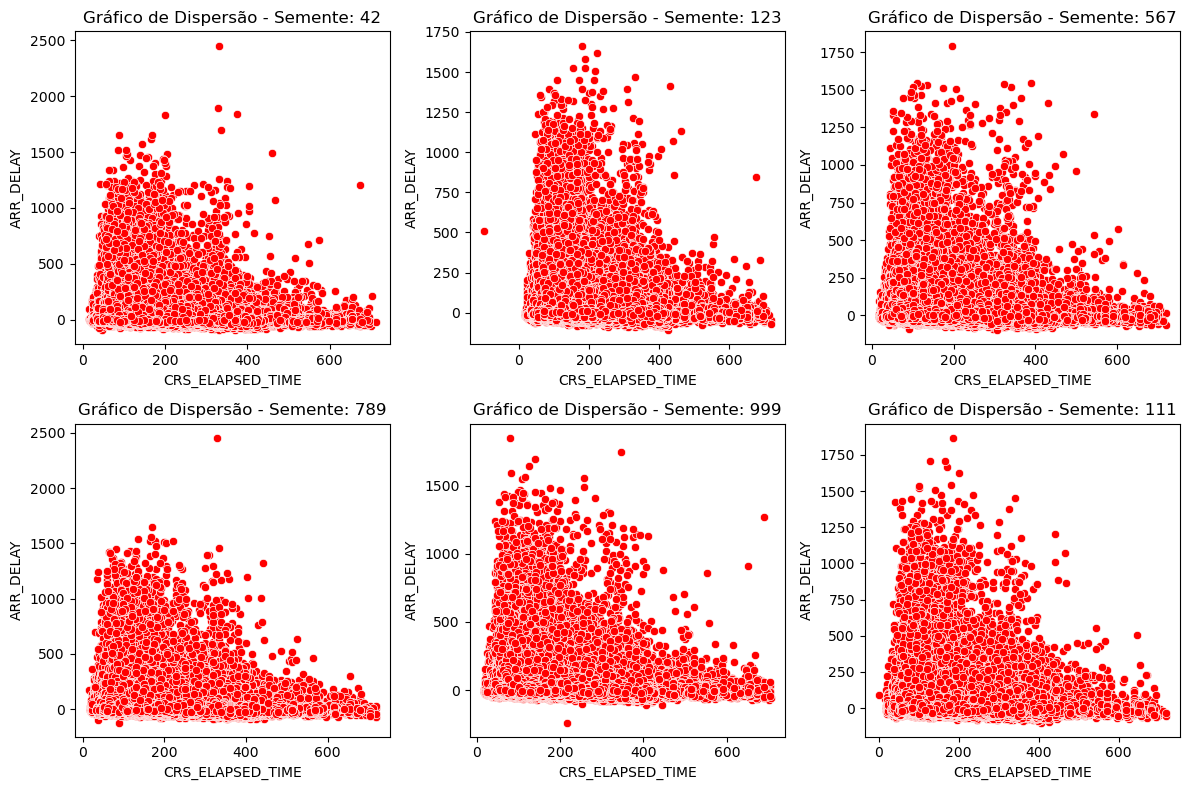

In [12]:
# Criando dataframe com as duas váriaveis
df_elapsed_time_delay = df_final.select("CRS_ELAPSED_TIME", "ARR_DELAY")

# Lista de sementes aleatórias
sementes_aleatorias = [42, 123, 567, 789, 999, 111]

# Configurar 
num_linhas = int(len(sementes_aleatorias) / 3)
num_colunas = 3  # Você pode ajustar o número de colunas conforme necessário
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(12,8))

# Loop através das sementes
for i, semente in enumerate(sementes_aleatorias):
    # Criar uma amostra do DataFrame usando a semente
    df_amostra = df_elapsed_time_delay.sample(withReplacement=False, fraction=0.05, seed=semente)

    # Coletar a amostra para o ambiente local (Pandas DataFrame)
    df_pandas = df_amostra.toPandas()

    # Realizar análise exploratória com Seaborn e Matplotlib
    # Converter axs[i] em um eixo individual usando [0]
    sns.scatterplot(x='CRS_ELAPSED_TIME', y='ARR_DELAY', data=df_pandas, ax=axs[i // num_colunas, i % num_colunas], color="red")
    axs[i // num_colunas, i % num_colunas].set_xlabel('CRS_ELAPSED_TIME')
    axs[i // num_colunas, i % num_colunas].set_ylabel('ARR_DELAY')
    axs[i // num_colunas, i % num_colunas].set_title(f'Gráfico de Dispersão - Semente: {semente}')

# Ajustar layout e exibir os subplots
plt.tight_layout()
plt.show()

Obsevando o resultado dos gráficos acima, não é possivel perceber nenhuma correlação evidente entre as duas variaveis analisadas.

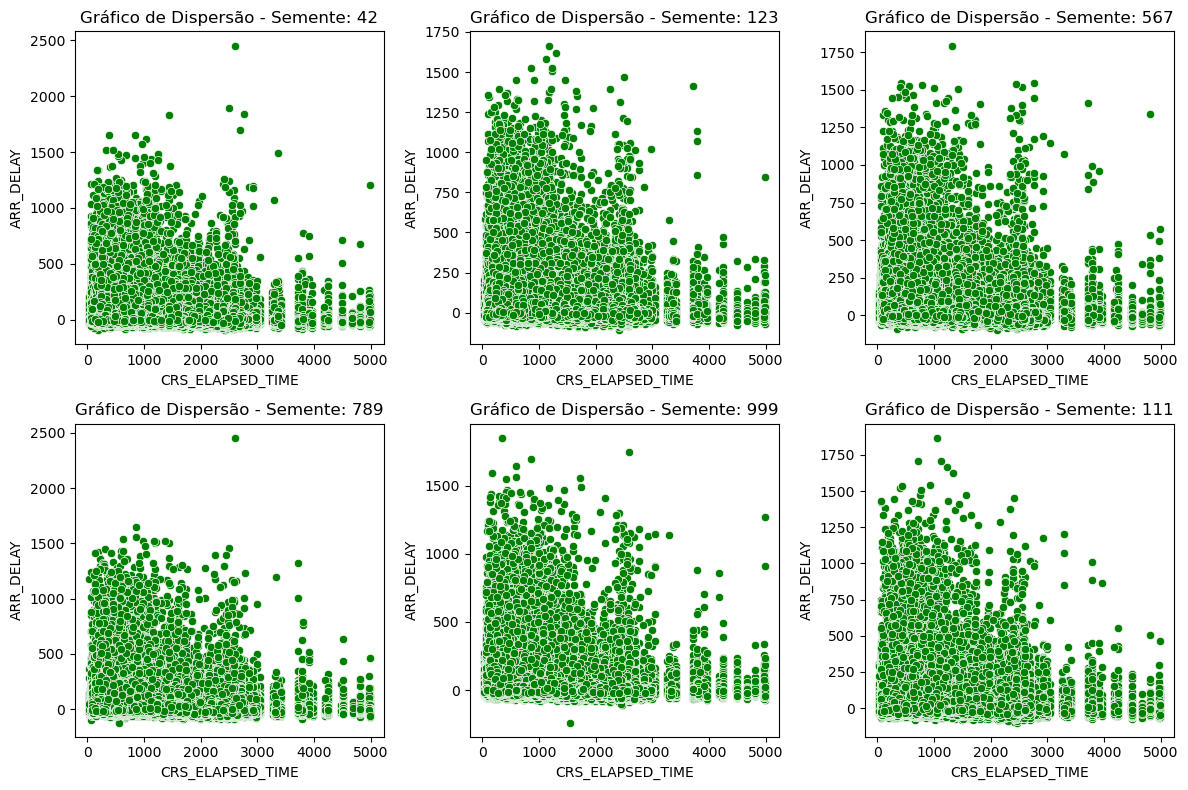

In [13]:
# Criando dataframe com as duas váriaveis
df_distance_delay = df_final.select("DISTANCE", "ARR_DELAY")

# Lista de sementes aleatórias
sementes_aleatorias = [42, 123, 567, 789, 999, 111]

# Configurar 
num_linhas = int(len(sementes_aleatorias) / 3)
num_colunas = 3  # Você pode ajustar o número de colunas conforme necessário
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(12,8))

# Loop através das sementes
for i, semente in enumerate(sementes_aleatorias):
    # Criar uma amostra do DataFrame usando a semente
    df_amostra = df_distance_delay.sample(withReplacement=False, fraction=0.05, seed=semente)

    # Coletar a amostra para o ambiente local (Pandas DataFrame)
    df_pandas = df_amostra.toPandas()

    # Realizar análise exploratória com Seaborn e Matplotlib
    # Converter axs[i] em um eixo individual usando [0]
    sns.scatterplot(x='DISTANCE', y='ARR_DELAY', data=df_pandas, ax=axs[i // num_colunas, i % num_colunas], color="green")
    axs[i // num_colunas, i % num_colunas].set_xlabel('CRS_ELAPSED_TIME')
    axs[i // num_colunas, i % num_colunas].set_ylabel('ARR_DELAY')
    axs[i // num_colunas, i % num_colunas].set_title(f'Gráfico de Dispersão - Semente: {semente}')

# Ajustar layout e exibir os subplots
plt.tight_layout()
plt.show()

Aparentemente o tempo de voo planejado não tem interferencia nos atrasos na aterrisagem.

### Categóricas

Nesta etapa da análise exploratória, vamos investigar como as variáveis categóricas selecionadas impactam nos atrasos na aterrissagem.

#### OP_CARRIER

In [14]:
# Obtendo o número de companhias presentes na base de dados
unique_op_carrier = df_final.select("OP_CARRIER").distinct()

# Transformando em um pandas dataframe
unique_op_carrier = unique_op_carrier.toPandas()

# Visualizando resultado
unique_op_carrier

,OP_CARRIER
0,UA
1,AA
2,NW
3,EV
4,B6
5,DL
6,OO
7,F9
8,YV
9,US


Existem 22 companhias areareas distintas na base de dados.from pyspark.sql.functions import col, mean, stddev

In [16]:
# Importando funções 
from pyspark.sql.functions import col, mean, stddev

In [17]:
# Agrupando e calculando media e desvio padrao
op_carrier_delay_mean = df_final.groupBy("OP_CARRIER").agg(
    mean(col("ARR_DELAY")).alias("media"),
    stddev(col("ARR_DELAY")).alias("desvio_padrao")
)

# Transfromando em um dataframe pandas
op_carrier_delay_mean = op_carrier_delay_mean.toPandas()

# Visualizando
op_carrier_delay_mean

,OP_CARRIER,media,desvio_padrao
0,UA,3.365959,42.636201
1,AA,5.178789,43.796708
2,NW,3.924208,38.119108
3,EV,8.455275,46.649647
4,B6,8.175117,44.386323
5,DL,1.207183,39.468081
6,OO,5.686691,42.816947
7,F9,9.156998,44.086855
8,YV,5.249744,39.215466
9,US,1.949251,29.667674


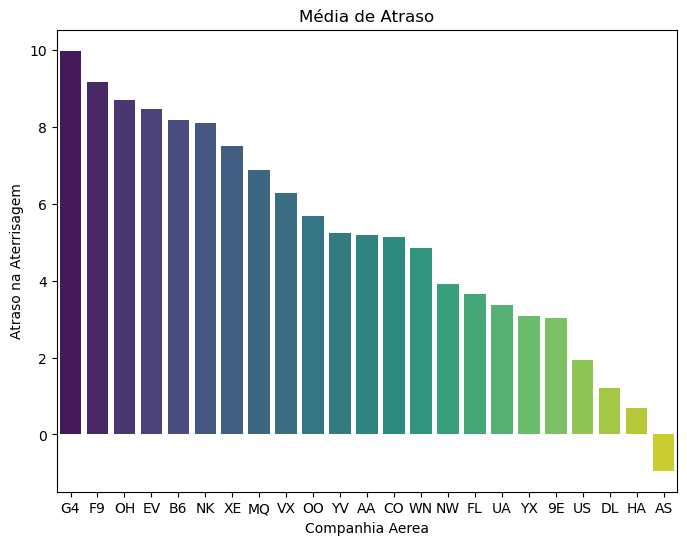

In [23]:
# Criar o gráfico de barra usando o Seaborn
plt.figure(figsize=(8, 6))  # Tamanho da figura (opcional)
sns.barplot(x='OP_CARRIER', y='media', data=op_carrier_delay_mean.sort_values("media", ascending=False), palette='viridis')

# Adicionar título e rótulos aos eixos
plt.title('Média de Atraso')
plt.xlabel('Companhia Aerea')
plt.ylabel('Atraso na Aterrisagem')

# Exibir o gráfico
plt.show()

Como isso vemos que a companhia com maior média de atraso é a G4.

Devido à presença de muitos valores zerados e negativos, os desvios padrões apresentaram valores consideravelmente elevados. A fim de adotar uma abordagem que atenue esse efeito, será conduzido o mesmo cálculo, porém, com a aplicação de um filtro nos atrasos. Dessa forma, obteremos as companhias aéreas com os maiores valores de atraso.

In [25]:
# Agrupando e calculando media e desvio padrao
op_carrier_delay_mean_2 = df_final.filter(col("ARR_DELAY").isNotNull() & (col("ARR_DELAY") > 0)).groupBy("OP_CARRIER").agg(
    mean(col("ARR_DELAY")).alias("media"),
    stddev(col("ARR_DELAY")).alias("desvio_padrao")
)

# Transfromando em um dataframe pandas
op_carrier_delay_mean_2 = op_carrier_delay_mean_2.toPandas()

# Visualizando
op_carrier_delay_mean_2

,OP_CARRIER,media,desvio_padrao
0,UA,37.754023,57.842694
1,AA,33.945064,59.582266
2,NW,25.816015,50.845748
3,EV,41.411221,61.575561
4,B6,40.769050,54.913378
5,DL,32.128068,58.346992
6,OO,33.802049,59.575925
7,F9,34.527619,55.401270
8,YV,32.814750,54.117170
9,US,25.451499,37.346803


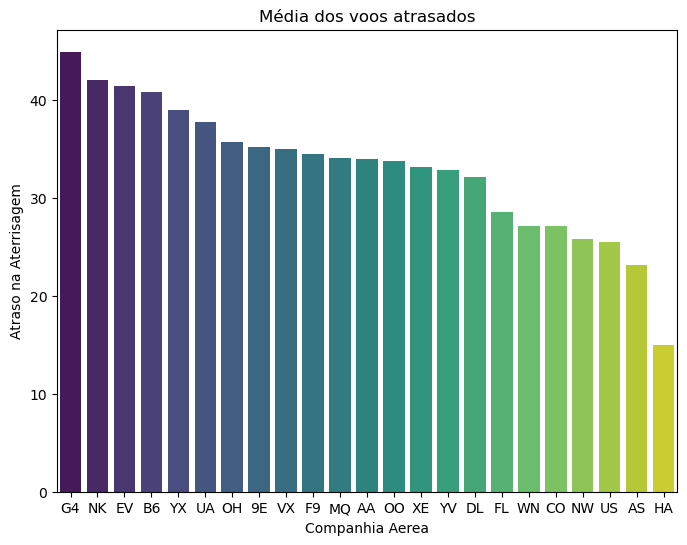

In [26]:
# Criar o gráfico de barra usando o Seaborn
plt.figure(figsize=(8, 6))  # Tamanho da figura (opcional)
sns.barplot(x='OP_CARRIER', y='media', data=op_carrier_delay_mean_2.sort_values("media", ascending=False), palette='viridis')

# Adicionar título e rótulos aos eixos
plt.title('Média dos voos atrasados')
plt.xlabel('Companhia Aerea')
plt.ylabel('Atraso na Aterrisagem')

# Exibir o gráfico
plt.show()

#### ORIGIN

Obtendo os aeroportos de partida com maior atraso médio.

In [28]:
# Agrupando e calculando media e desvio padrao
origin_delay_mean = df_final.groupBy("ORIGIN").agg(
    mean(col("ARR_DELAY")).alias("media"),
    stddev(col("ARR_DELAY")).alias("desvio_padrao")
)

# Transfromando em um dataframe pandas
origin_delay_mean = origin_delay_mean.toPandas()

# Visualizando
origin_delay_mean

,ORIGIN,media,desvio_padrao
0,BGM,2.177006,56.320380
1,PSE,-0.212437,34.970561
2,MSY,4.001413,37.920180
3,GEG,0.225221,33.705127
4,BUR,2.802096,30.110426
...,...,...,...
375,SLN,25.258209,108.602113
376,PGV,12.075702,61.673536
377,HHH,5.558416,38.505373
378,EAR,-14.613065,33.861065


Como temos um número elevado de aeroportos, iremos ánalisar os top10 aeroportos com maior e menor média de atraso.

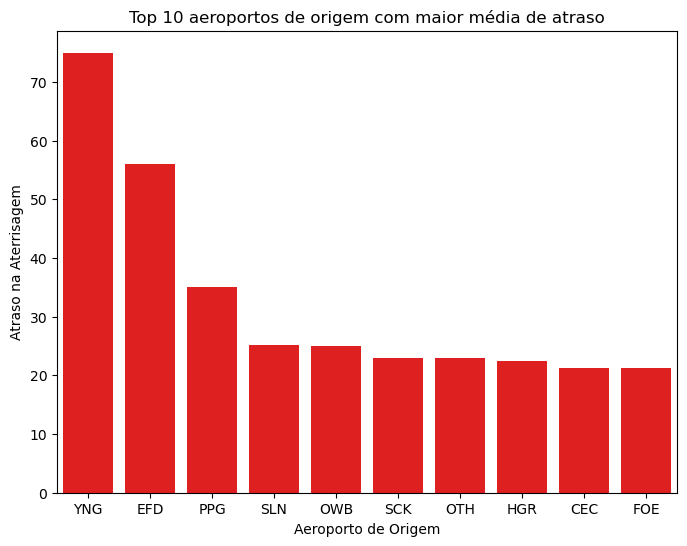

In [31]:
# Criar o gráfico de barra usando o Seaborn
plt.figure(figsize=(8, 6))  # Tamanho da figura (opcional)
sns.barplot(x='ORIGIN', y='media', data=origin_delay_mean.sort_values("media", ascending=False).head(10), color='red')

# Adicionar título e rótulos aos eixos
plt.title('Top 10 aeroportos de origem com maior média de atraso')
plt.xlabel('Aeroporto de Origem')
plt.ylabel('Atraso na Aterrisagem')

# Exibir o gráfico
plt.show()

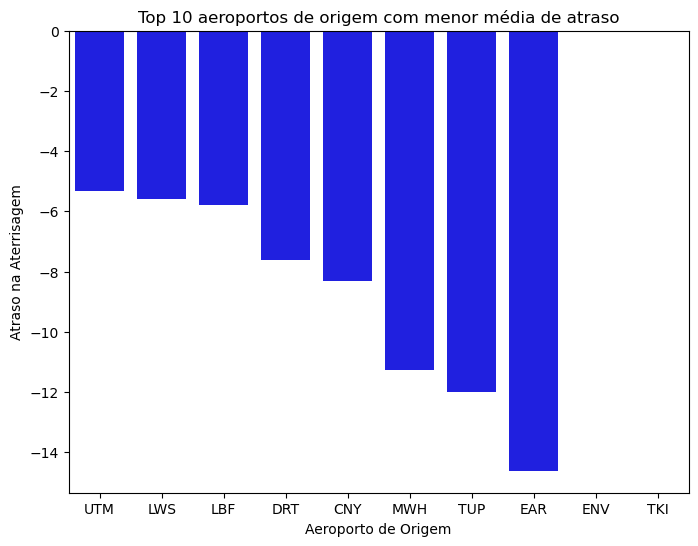

In [32]:
# Criar o gráfico de barra usando o Seaborn
plt.figure(figsize=(8, 6))  # Tamanho da figura (opcional)
sns.barplot(x='ORIGIN', y='media', data=origin_delay_mean.sort_values("media", ascending=False).tail(10), color='blue')

# Adicionar título e rótulos aos eixos
plt.title('Top 10 aeroportos de origem com menor média de atraso')
plt.xlabel('Aeroporto de Origem')
plt.ylabel('Atraso na Aterrisagem')

# Exibir o gráfico
plt.show()

#### DEST

Nesta etapa iremos analisar os aeroportos que mais recebem voos atrasados com base na média.

In [34]:
# Agrupando e calculando media e desvio padrao
dest_delay_mean = df_final.groupBy("DEST").agg(
    mean(col("ARR_DELAY")).alias("media"),
    stddev(col("ARR_DELAY")).alias("desvio_padrao")
)

# Transfromando em um dataframe pandas
dest_delay_mean = dest_delay_mean.toPandas()

# Visualizando
dest_delay_mean

,DEST,media,desvio_padrao
0,BGM,4.904718,45.518035
1,PSE,10.596906,37.654098
2,MSY,4.135964,33.706404
3,GEG,3.115411,29.119264
4,BUR,4.155654,26.871427
...,...,...,...
373,SLN,12.740686,87.748869
374,PGV,18.991525,52.903399
375,HHH,6.980040,49.083313
376,EAR,-4.727273,56.390106


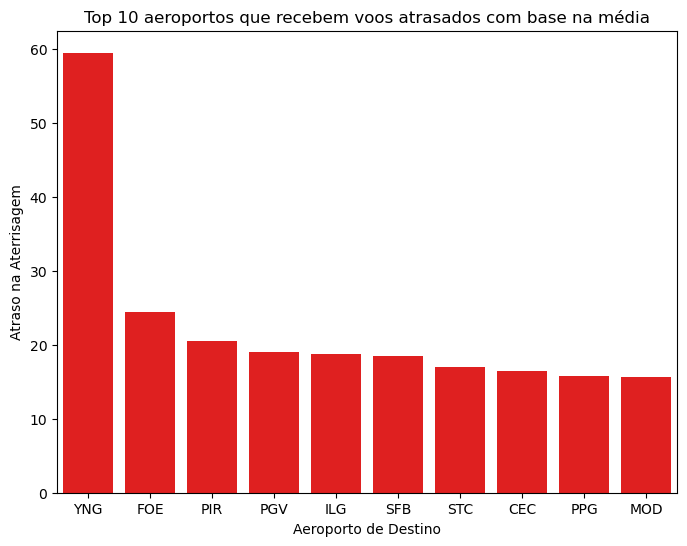

In [36]:
# Criar o gráfico de barra usando o Seaborn
plt.figure(figsize=(8, 6))  # Tamanho da figura (opcional)
sns.barplot(x='DEST', y='media', data=dest_delay_mean.sort_values("media", ascending=False).head(10), color='red')

# Adicionar título e rótulos aos eixos
plt.title('Top 10 aeroportos que recebem voos atrasados com base na média')
plt.xlabel('Aeroporto de Destino')
plt.ylabel('Atraso na Aterrisagem')

# Exibir o gráfico
plt.show()

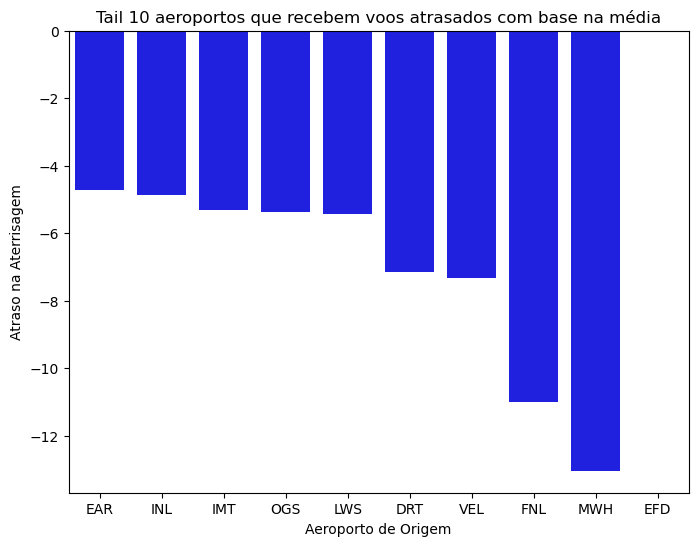

In [38]:
# Criar o gráfico de barra usando o Seaborn
plt.figure(figsize=(8, 6))  # Tamanho da figura (opcional)
sns.barplot(x='DEST', y='media', data=dest_delay_mean.sort_values("media", ascending=False).tail(10), color='blue')

# Adicionar título e rótulos aos eixos
plt.title('Tail 10 aeroportos que recebem voos atrasados com base na média')
plt.xlabel('Aeroporto de Origem')
plt.ylabel('Atraso na Aterrisagem')

# Exibir o gráfico
plt.show()

# Modelagem

In [12]:
# This list includes all values not known at the moment of takeoff
# except `ARR_DELAY` which will be used as target variable
take_off_leak = ["WHEELS_ON","TAXI_IN","ARR_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME",
                 "CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]

In [13]:
take_off_df = df_final.drop(*take_off_leak)\
                      .filter(df_final.CANCELLED == 0)\
                      .filter(df_final.DIVERTED == 0)\
                      .filter(df_final.CRS_ARR_TIME.isNotNull())\
                      .filter(df_final.ARR_DELAY.isNotNull())\
                      .filter(df_final.DEP_DELAY.isNotNull())

In [14]:
missing_counts = take_off_df.select([sf.col(column).isNull().cast("int").alias(column) for column in take_off_df.columns]) \
                       .groupBy() \
                       .sum()

In [15]:
# Criando dataframe de colunas com valores zerados
missing_counts_df = missing_counts.toPandas().transpose()

# Filtrando apenas colunas com valores nulos
missing_counts_df = missing_counts_df[missing_counts_df[0]>0]

# Renomeando a coluna
missing_counts_df = missing_counts_df.rename(columns={0:"nulos"})

In [16]:
# Cálculando porcentagem de valores faltantes
missing_counts_df["%nulos"] = (missing_counts_df["nulos"]/OBSERVACOES) * 100

# Ordenando por % de nulos
missing_counts_df = missing_counts_df.sort_values("%nulos", ascending=False)

# Visualizando resultados
missing_counts_df

,nulos,%nulos
sum(CANCELLATION_CODE),54425644,88.415088
sum(CRS_ELAPSED_TIME),1,0.000002


## Train/Test Split

In [17]:
train_df, test_df = take_off_df.randomSplit([0.8,0.2], seed=42)
toy_df = train_df.sample(False, 0.01, seed=42)

In [ ]:
print("Train set count:", train_df.count())
print("Test set count:", test_df.count())
print("Toy set count:", toy_df.count())

## Feature Engineering: One-Hot-Enconding

In [18]:
cat_features = ["OP_CARRIER", "OP_CARRIER_FL_NUM", "ORIGIN", "DEST"]

indexOutputCols = [x + 'Index' for x in cat_features]

oheOutputCols = [x + 'OHE' for x in cat_features]

stringIndex = StringIndexer(inputCols = cat_features,
                            outputCols = indexOutputCols,
                            handleInvalid = 'skip')

oheEncoder = OneHotEncoder(inputCols = indexOutputCols,
                           outputCols = oheOutputCols)

In [19]:
num_features = ["TAXI_OUT", "DEP_DELAY", "CRS_ELAPSED_TIME", "DISTANCE"]

numVecAssembler = VectorAssembler(inputCols = num_features,
                                  outputCol = 'features',
                                  handleInvalid = 'skip')

stdScaler = StandardScaler(inputCol = 'features',
                           outputCol = 'features_scaled')

## Assembling dos vetores

In [20]:
assembleInputs = oheOutputCols + ['features_scaled']

vecAssembler = VectorAssembler(inputCols = assembleInputs,
                               outputCol = 'features_vector')

In [21]:
stages = [stringIndex, oheEncoder, numVecAssembler, stdScaler, vecAssembler]

## Criação do Pipeline

In [22]:
# Criacao do pipeline de transformacao
transform_pipeline = Pipeline(stages=stages)

# Aplicacao do pipeline nos dados de treino
fitted_transformer = transform_pipeline.fit(train_df)
transformed_train_df = fitted_transformer.transform(train_df)

transformed_train_df.limit(10).toPandas()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,OP_CARRIER_FL_NUMIndex,ORIGINIndex,DESTIndex,OP_CARRIEROHE,OP_CARRIER_FL_NUMOHE,ORIGINOHE,DESTOHE,features,features_scaled,features_vector
0,2009-01-01,9E,2102,AUS,IND,1655,1650.0,-5.0,19.0,1709.0,...,2722.0,36.0,48.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[19.0, -5.0, 155.0, 920.0]","[2.0237826918319213, -0.13391154613205383, 2.1...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2009-01-01,9E,2103,IND,AUS,1445,1450.0,5.0,14.0,1504.0,...,2374.0,48.0,36.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[14.0, 5.0, 150.0, 920.0]","[1.4912082992445737, 0.13391154613205383, 2.03...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2009-01-01,9E,2109,MSP,OKC,2130,2126.0,-4.0,34.0,2200.0,...,2747.0,11.0,61.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[34.0, -4.0, 133.0, 695.0]","[3.621505869593965, -0.10712923690564306, 1.80...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2009-01-01,9E,2110,OKC,MSP,1745,1740.0,-5.0,8.0,1748.0,...,2119.0,61.0,11.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.0, -5.0, 132.0, 695.0]","[0.8521190281397564, -0.13391154613205383, 1.7...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2009-01-01,9E,2114,ALO,MSP,700,815.0,75.0,16.0,831.0,...,2233.0,306.0,11.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[16.0, 75.0, 69.0, 166.0]","[1.7042380562795127, 2.0086731919808076, 0.938...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,2009-01-01,9E,2118,MSP,GRR,1310,1337.0,27.0,14.0,1351.0,...,1901.0,11.0,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[14.0, 27.0, 93.0, 408.0]","[1.4912082992445737, 0.7231223491130907, 1.264...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,2009-01-01,9E,2122,CLE,MSP,1343,1338.0,-5.0,11.0,1349.0,...,2105.0,38.0,11.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[11.0, -5.0, 135.0, 622.0]","[1.171663663692165, -0.13391154613205383, 1.83...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,2009-01-01,9E,2122,MSP,RHI,1538,1549.0,11.0,12.0,1601.0,...,2105.0,11.0,273.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[12.0, 11.0, 58.0, 190.0]","[1.2781785422096346, 0.29460540149051845, 0.78...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,2009-01-01,9E,2123,DTW,GRR,1218,1214.0,-4.0,16.0,1230.0,...,2532.0,9.0,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[16.0, -4.0, 62.0, 120.0]","[1.7042380562795127, -0.10712923690564306, 0.8...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

## Model Training

In [23]:
model = LinearRegression(maxIter = 5, # pode causar overfitting
                         solver = 'auto',
                         labelCol = 'ARR_DELAY',
                         featuresCol = 'features_vector',
                         elasticNetParam = 0.2,
                         regParam = 0.02)

pipe_stages = stages + [model]

pipe = Pipeline(stages=pipe_stages)

In [24]:
fitted_pipe = pipe.fit(toy_df)

## Model performance evaluation

In [25]:
preds = fitted_pipe.transform(test_df)

In [26]:
preds.limit(10).toPandas()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,ORIGINIndex,DESTIndex,OP_CARRIEROHE,OP_CARRIER_FL_NUMOHE,ORIGINOHE,DESTOHE,features,features_scaled,features_vector,prediction
0,2009-01-01,9E,2108,OKC,MSP,700,650.0,-10.0,15.0,705.0,...,61.0,11.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[15.0, -10.0, 135.0, 695.0]","[1.592625007550886, -0.2683625025834257, 1.834...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-15.030487
1,2009-01-01,9E,2115,MSP,ALO,2245,2245.0,0.0,31.0,2316.0,...,11.0,316.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[31.0, 0.0, 58.0, 166.0]","[3.2914250156051645, 0.0, 0.7881109483871731, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.436105
2,2009-01-01,9E,2120,STL,MSP,1610,1552.0,-18.0,7.0,1559.0,...,29.0,11.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.0, -18.0, 110.0, 449.0]","[0.7432250035237469, -0.4830525046501663, 1.49...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-29.290478
3,2009-01-01,9E,2125,MSP,CLE,1015,1014.0,-1.0,23.0,1037.0,...,11.0,40.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[23.0, -1.0, 117.0, 622.0]","[2.4420250115780253, -0.026836250258342572, 1....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-5.115942
4,2009-01-01,9E,2138,SAT,IND,1915,1916.0,1.0,14.0,1930.0,...,43.0,47.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[14.0, 1.0, 164.0, 986.0]","[1.4864500070474937, 0.026836250258342572, 2.2...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-6.717591
5,2009-01-01,9E,2143,CMX,MSP,545,550.0,5.0,17.0,607.0,...,262.0,11.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[17.0, 5.0, 82.0, 277.0]","[1.8049750085576708, 0.13418125129171285, 1.11...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.606369
6,2009-01-01,9E,2149,MSP,GRB,1259,1259.0,0.0,11.0,1310.0,...,11.0,119.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[11.0, 0.0, 70.0, 252.0]","[1.1679250055373165, 0.0, 0.9511683859845192, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-10.853533
7,2009-01-01,9E,2156,AZO,MSP,710,711.0,1.0,19.0,730.0,...,183.0,11.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[19.0, 1.0, 108.0, 426.0]","[2.0173250095644555, 0.026836250258342572, 1.4...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2.881877
8,2009-01-01,9E,2168,BDL,IND,1620,1626.0,6.0,18.0,1644.0,...,56.0,47.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[18.0, 6.0, 155.0, 728.0]","[1.9111500090610631, 0.16101750155005543, 2.10...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [27]:
rmse = RegressionEvaluator(labelCol = 'ARR_DELAY',
                           metricName = 'rmse').evaluate(preds)

In [28]:
print("RMSEof Prediction on test set:", rmse)

RMSEof Prediction on test set: 10.060889556975196


In [32]:
results = []
results.append({"run": 1,
                "rmse": rmse,
                "model": "LinearRegression",
                "params": "maxIter = 5, solver = 'auto', labelCol = 'ARR_DELAY', featuresCol = 'features_vector', elasticNetParam = 0.2, regParam = 0.02"})

In [29]:
df_final.drop(*take_off_leak)\
                      .filter(df_final.CANCELLED == 0)\
                      .filter(df_final.DIVERTED == 0)\
                      .filter(df_final.CRS_ARR_TIME.isNotNull())\
                      .filter(df_final.ARR_DELAY.isNotNull())\
                      .filter(df_final.DEP_DELAY.isNotNull()).count()

54425644